In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import emcee
import corner

import uncertainties as un
import uncertainties.unumpy as unp
from uncertainties.unumpy import nominal_values, std_devs
err = std_devs
nom = nominal_values

from li_funks.plot import savefig

In [3]:
df = pd.read_pickle('data/processed_LiDataFull.pkl')  # use pickle to preserve uncertainty info
sdf = pd.read_pickle('data/processed_LiDataSummary.pkl')  # use pickle to preserve uncertainty info

lit = pd.read_pickle('data/processed_LiDataLiterature.pkl')
inorg = lit.loc['calcite']
fug = inorg.loc['Fuger2019']

In [4]:
rdict = {
    'Fuger2019': 'Fuger et al. (2019, 2022)',
    'This Study': 'This Study',
}

mdict = {
    'Fuger2019': 's',
    'This Study': 'o',
}

In [5]:
# df[database]

In [190]:
# compile data

database = 'pitzer_Li'

# Independent Variables
Rp = np.concatenate([nom(df.R.R_13C), nom(10**fug.solid.logR)])
Rp_err = err(df.R.R_13C)
Rp_err = np.concatenate([Rp_err, np.full(Rp.size - Rp_err.size, Rp_err.mean() * 2)])
logRp = np.log10(Rp)

ind_fuger = np.zeros(Rp.shape, dtype=bool)
ind_fuger[df.shape[0]:] = True
ind_this = np.zeros(Rp.shape, dtype=bool)
ind_this[:df.shape[0]] = True

mu = np.concatenate([df[database, 'mu'].values, fug[database, 'mu'].values])
temp = np.concatenate([df[database, 'temp(C)'].values, fug[database, 'temp(C)'].values])
DIC = np.concatenate([df[database, 'C(mol/kgw)'].values, fug[database, 'C(mol/kgw)'].values])

la_OH = np.concatenate([df[database, 'la_OH-'].values, fug[database, 'la_OH-'].values])
OH = 10**la_OH

la_HCO3 = np.concatenate([df[database, 'la_HCO3-'].values, fug[database, 'la_HCO3-'].values])
HCO3 = 10**la_HCO3

la_CO3 = np.concatenate([df[database, 'la_CO3-2'].values, fug[database, 'la_CO3-2'].values])
CO3 = 10**la_CO3

la_LiOH = np.concatenate([df[database, 'la_LiOH'].values, fug[database, 'la_LiOH'].values])
LiOH = 10**la_LiOH

la_Ca = np.concatenate([df[database, 'la_Ca+2'].values, fug[database, 'la_Ca+2'].values])
m_Ca  = 10**la_Ca

la_NaHCO3 = np.concatenate([df['llnl', 'la_NaHCO3'].values, fug['llnl', 'la_NaHCO3'].values])
NaHCO3 = 10**la_NaHCO3

la_LiHCO3 = np.concatenate([df['llnl_LiHCO3', 'la_LiHCO3'].values, fug['llnl_LiHCO3', 'la_LiHCO3'].values])
LiHCO3 = 10**la_LiHCO3

la_Li = np.concatenate([df[database, 'la_Li+'].values, fug[database, 'la_Li+'].values])
m_Li = np.concatenate([df[database, 'm_Li+(mol/kgw)'].values, fug[database, 'm_Li+(mol/kgw)'].values])

Li_activity_ratio = 10**la_Li / m_Li

study = np.concatenate([np.full(df.shape[0], 'This Study'), np.full(fug.shape[0], 'Fuger2019')])

# Li Partitioning
DLi = np.concatenate([nom(df.OG.DLi), nom(fug.solid.DLi)])
DLi_err = np.concatenate([err(df.OG.DLi), fug.solid.DLi_2std * 2])
uDLi = unp.uarray(DLi, DLi_err)

sol_Li = np.concatenate([df.solution.Li, fug.solution.Li])
sol_Ca = np.concatenate([df.solution.Ca, fug.solution.Ca])
sol_LiCa = sol_Li / sol_Ca
usolid_LiCa = uDLi * sol_LiCa
solid_LiCa = nom(usolid_LiCa)
solid_LiCa_err = err(usolid_LiCa)

e7Li = np.concatenate([nom(df.Li_isotopes_vs_fluid.epsilon_og), nom(fug.solid.epsilon_7Li)])
e7Li_err = np.concatenate([err(df.Li_isotopes_vs_fluid.epsilon_og), fug.solid.epsilon_7Li_2std / 2])

# e7Li_err = e7Li_err[~np.isnan(e7Li)]
# e7Li = e7Li[~np.isnan(e7Li)]


## Standard SKM

In [8]:
def SKM(Rp, Kf, Keq, Rb=6e-7):
    """
    DePaolo's (2011) Surface Kinetic Model
    
    Parameters
    ----------
    Kf : array-like
        The kinetic ('forward') fractionation factor.
        Kp will asymptote towards this value at high
        Rp.
    Keq : array-like
        The equilibrium fractionation factor. Kp will
        asymptote towards this values at low Rp.
    Rp : array-like
        Precipitation rate.
    Rb : array-like
        Ion detachment rate.

    Returns
    -------
    Kp : array-like
        Partitioning / fractionation of element in precipitated mineral.
    """
    return Kf / (1 + Rb * (Kf / Keq - 1) / (Rp + Rb))

logRb_prior = stats.truncnorm(loc=-7, scale=1, a=-3, b=2)

def log_prior(theta):
    Kf, Keq, logRb = theta
    if np.any(Kf < 0) or np.any(Keq < 0):
        return -np.inf

    return np.sum(logRb_prior.logpdf(logRb))
    
def log_likelihood(theta, Rp, DLi, Rp_err, DLi_err):
    Kf, Keq, logRb = theta
    model = SKM(Rp, Kf, Keq, 10**logRb)
    sigma2 = DLi_err**2 + Rp_err**2
    return -0.5 * np.sum((DLi - model)**2 / sigma2 + np.log(sigma2))

def log_probability(theta, Rp, DLi, Rp_err, DLi_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, Rp, DLi, Rp_err, DLi_err)

(array([ 8.,  1., 48.,  1.,  7.,  6.,  0.,  0.,  0.,  4.]),
 array([-3.07648112, -2.9471357 , -2.81779028, -2.68844486, -2.55909943,
        -2.42975401, -2.30040859, -2.17106317, -2.04171775, -1.91237232,
        -1.7830269 ]),
 <BarContainer object of 10 artists>)

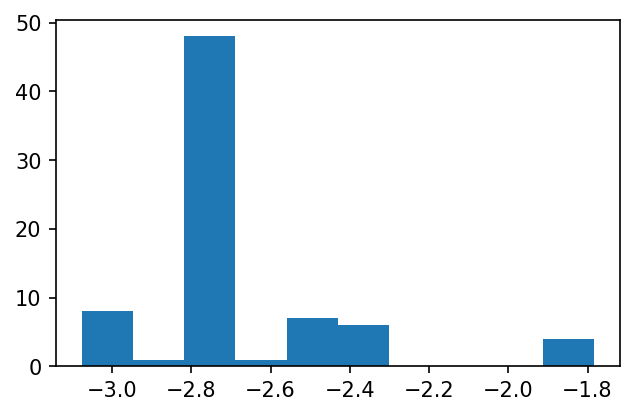

In [9]:
plt.hist(la_HCO3)

In [147]:
initial = 0.0014, 1e-5, -7

nwalkers = 32
ndim = len(initial)

start = initial + 1e-7 * np.random.randn(nwalkers, len(initial))

ind = np.isclose(la_HCO3, -2.8, atol=0.2)
# ind = np.isclose(la_OH, -6, atol=0.3)
# ind = np.ones(Rp.shape, dtype=bool)
inputs = (Rp[ind], DLi[ind], Rp_err[ind], DLi_err[ind])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=inputs)
sampler.run_mcmc(start, 5000, progress=True);


100%|██████████| 5000/5000 [00:20<00:00, 241.99it/s]


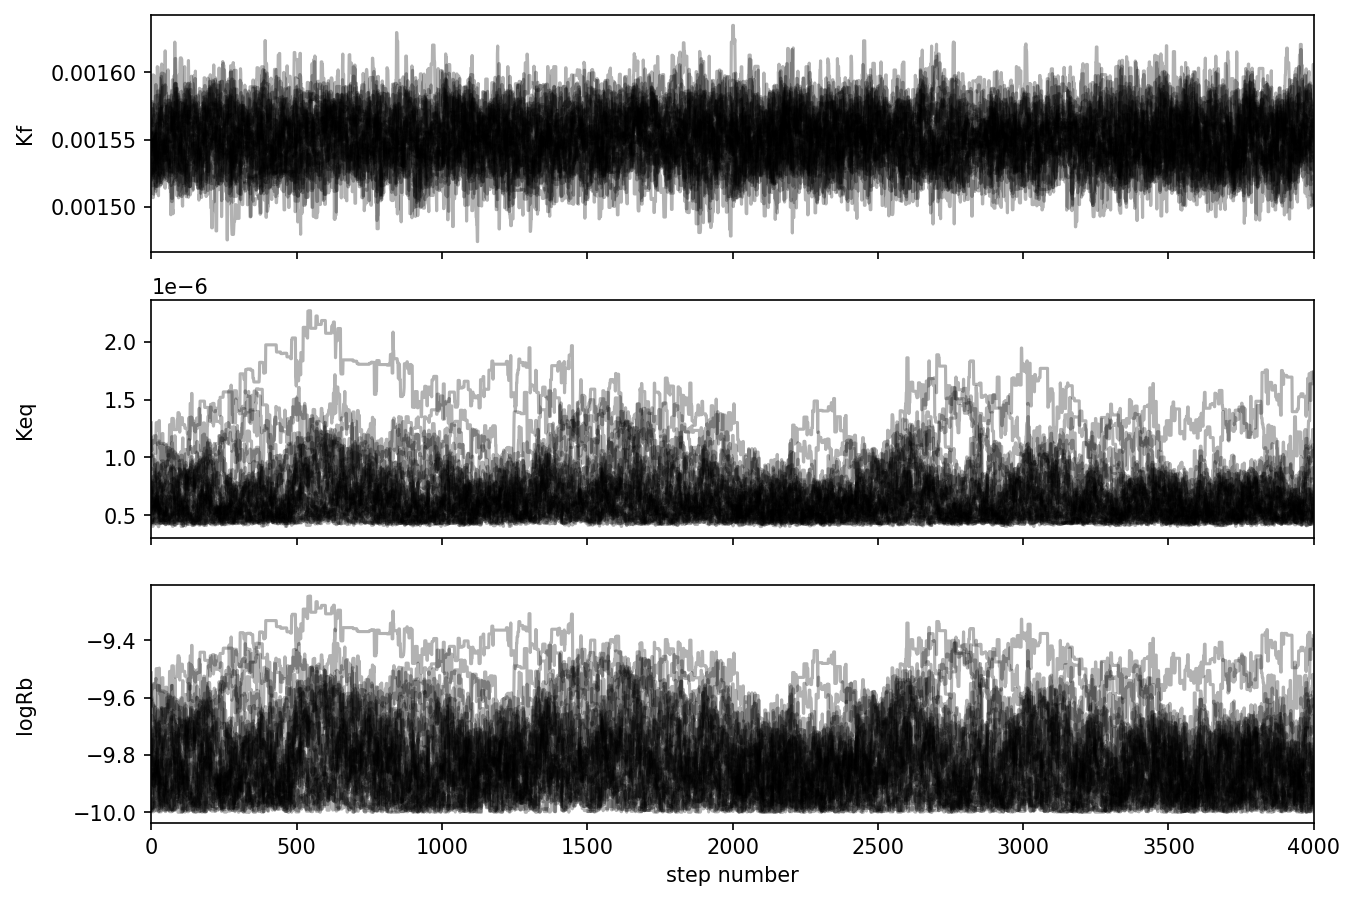

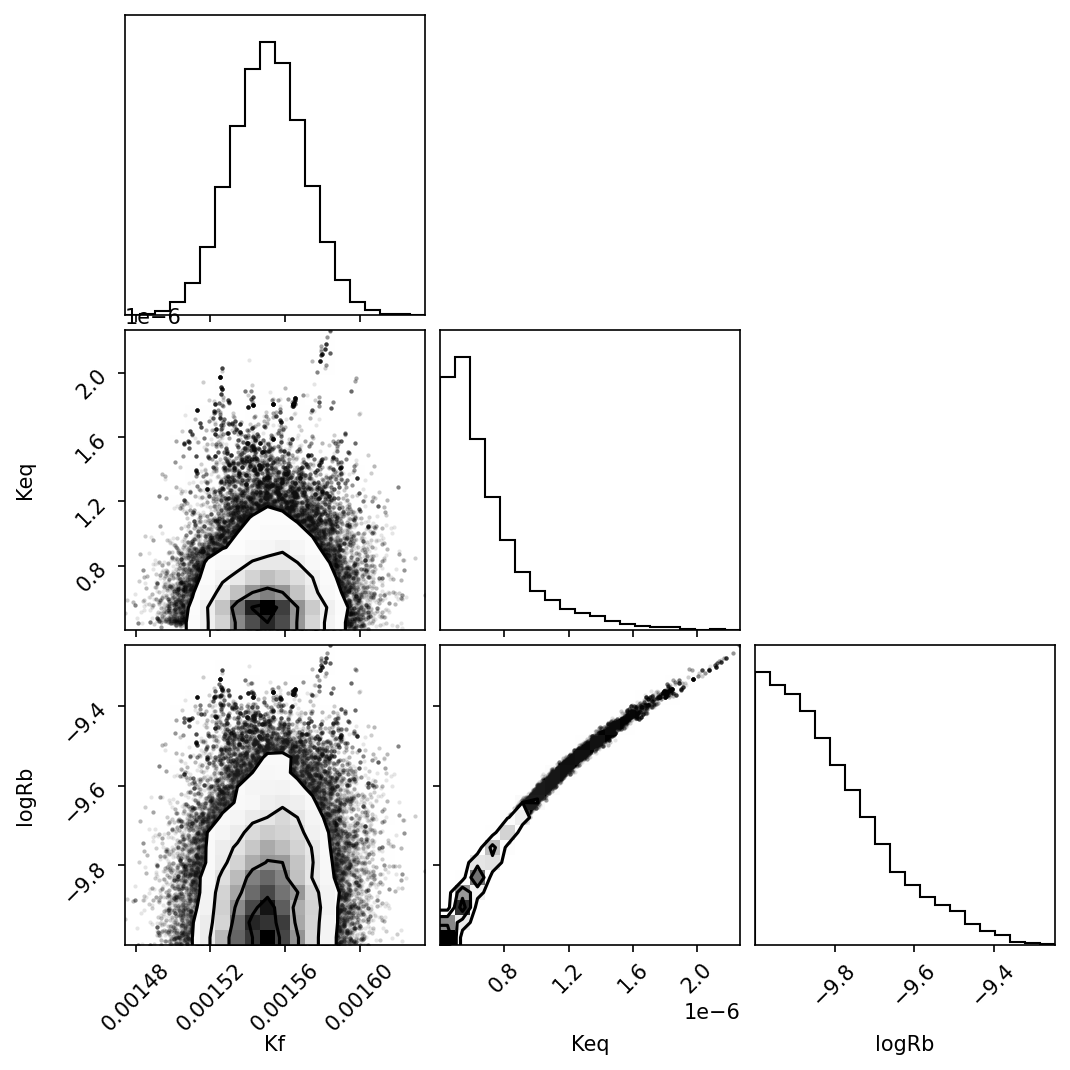

In [148]:
burnin=1000
samples = sampler.get_chain(discard=burnin)
flat_samples = sampler.get_chain(discard=burnin, flat=True)
basic_skm = np.median(flat_samples, axis=0)
labels = 'Kf', 'Keq', 'logRb'

fig, axs = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axs[-1].set_xlabel("step number");

corner.corner(flat_samples, labels=labels);

In [149]:
CI = 0.95
qs = np.quantile(flat_samples, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=0).T

qs[:,-1] - qs[:,0]

array([7.59608933e-05, 9.82740045e-07, 5.19580703e-01])

In [150]:
qs[:,1]

array([ 1.55081891e-03,  6.07131296e-07, -9.84415354e+00])

In [151]:
nRp = np.logspace(-8.5, -5, 100)
pred = SKM(nRp.reshape(-1,1), flat_samples[:,0], flat_samples[:,1], 10**flat_samples[:,2])

CI = 0.95
plo, pmid, phi = np.quantile(pred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

In [152]:
# plt.scatter(la_OH, la_HCO3)

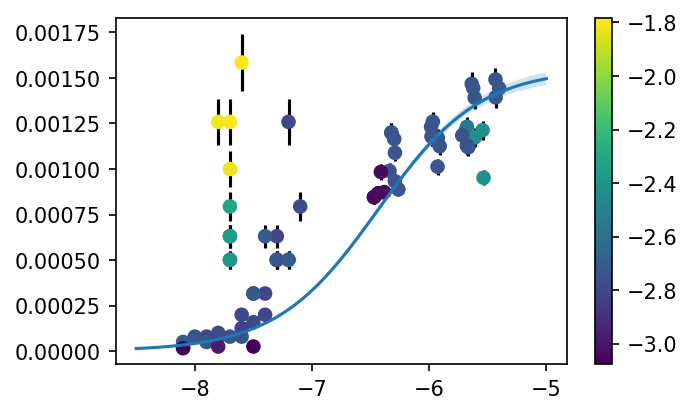

In [153]:
# laOH invariant
# ind = np.isclose(la_OH, -6, atol=0.5)

# plt.errorbar(np.log10(Rp[ind]), DLi[ind], yerr=DLi_err[ind], fmt='none', c='k', zorder=-3)
# plt.scatter(np.log10(Rp[ind]), DLi[ind], c=la_HCO3[ind])

plt.errorbar(np.log10(Rp), DLi, yerr=DLi_err, fmt='none', c='k', zorder=-3)
plt.scatter(np.log10(Rp), DLi, c=la_HCO3)

plt.plot(np.log10(nRp), pmid)
plt.fill_between(np.log10(nRp), plo, phi, alpha=0.2)

plt.colorbar()

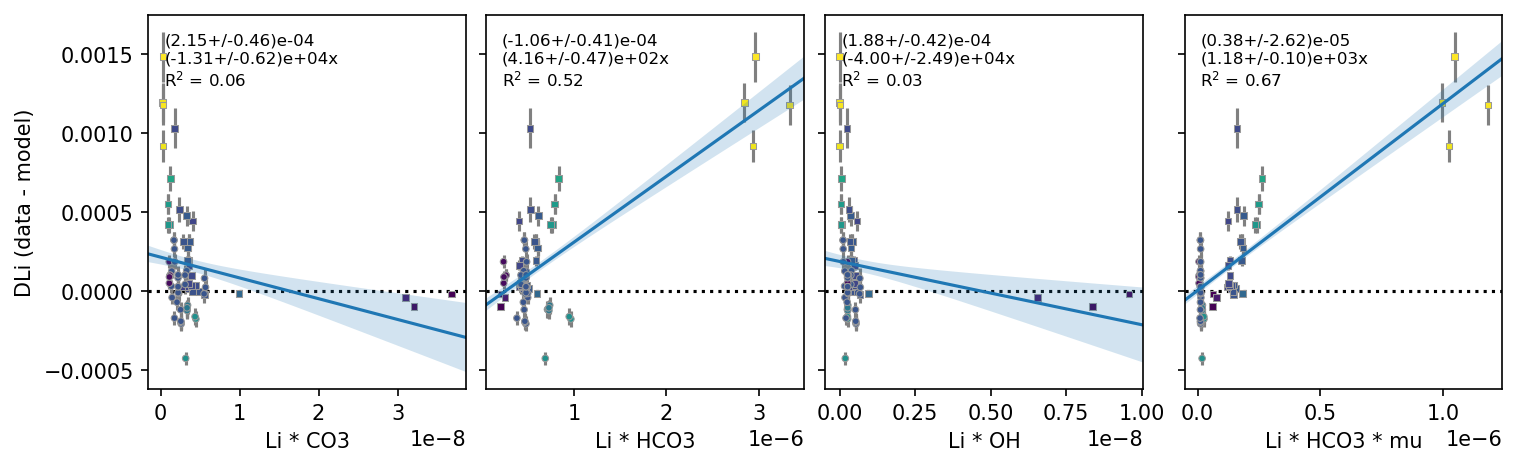

In [196]:
dpred = SKM(Rp.reshape(-1,1), flat_samples[:,0], flat_samples[:,1], 10**flat_samples[:,-1])

dplo, dpmid, dphi = np.quantile(dpred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

resid = DLi - dpmid
y = resid

# ratio = DLi / dpmid
# y = ratio


Li_CO3 = 10**la_Li * 10**la_CO3
Li_HCO3 = 10**la_Li * 10**la_HCO3
Li_OH = 10**la_Li * 10**la_OH

cvar = la_HCO3

copts = {
    'vmin': cvar.min(),
    'vmax': cvar.max(),
}

xvars = [
    # (mu, 'Ionic Strength',),
    # (sol_LiCa, 'Solution Li/Ca',),
    # (Li_activity_ratio, 'Li activity ratio',), 
    # (la_Li, '$log_{10}(\\alpha_{Li})$',),
    # (la_HCO3, '$log_{10}(\\alpha_{HCO3})$',),
    # (la_CO3, '$log_{10}(\\alpha_{CO3})$',),
    # (la_OH, '$log_{10}(\\alpha_{OH})$',),
    # (la_LiOH, '$log_{10}(\\alpha_{LiOH})$',),
    # (10**la_HCO3, '$\\alpha_{HCO3}$',),
    # (10**la_CO3, '$\\alpha_{CO3}$',),
    # (10**la_OH, '$\\alpha_{OH}$',),
    (Li_CO3, 'Li * CO3',),
    (Li_HCO3, 'Li * HCO3',),
    (Li_OH, 'Li * OH',),
    (Li_HCO3 * mu, 'Li * HCO3 * mu',),
    ]


fig, axs = plt.subplots(1, len(xvars), figsize=[2.5 * len(xvars), 3], sharey=True, constrained_layout=True)

for i, (xv, label) in enumerate(xvars):
    ax = axs[i]
    # for s in ['Fuger2019']:
    for s in np.unique(study):
        ind = study == s

        ax.scatter(xv[ind], y[ind], s=10, c=cvar[ind], marker=mdict[s], lw=0.5, edgecolor=(.6,.6,.6), **copts)
        ax.errorbar(xv[ind], y[ind], yerr=DLi_err[ind], fmt='none', c='grey', zorder=-3)
        ax.set_xlabel(label)
        
    up = un.correlated_values(*np.polyfit(xv, y, 1, cov=True))
    # up = un.correlated_values(*np.polyfit(xv[ind_fuger], y[ind_fuger], 2, cov=True))
    
    xlim = ax.get_xlim()
    ax.set_xlim(xlim)
    xn = np.linspace(*xlim)
    pred = np.polyval(up, xn)
    
    r2 = r2_score(y, nom(np.polyval(up, xv)))
    
    ax.plot(xn, nom(pred))
    ax.fill_between(xn, nom(pred) - err(pred), nom(pred) + err(pred), alpha=0.2)
    ax.text(0.05, 0.95, f'{up[1]:.2e}\n{up[0]:.2e}x\n$R^2$ = {r2:.2f}', transform=ax.transAxes, va='top', ha='left', fontsize=8)
        
axs[0].set_ylabel('DLi (data - model)')

# plt.colorbar()

for ax in axs:
    ax.axhline(0, ls=':', c='k', zorder=-1)
    # ax.axhline(1, ls=':', c='k', zorder=-1)

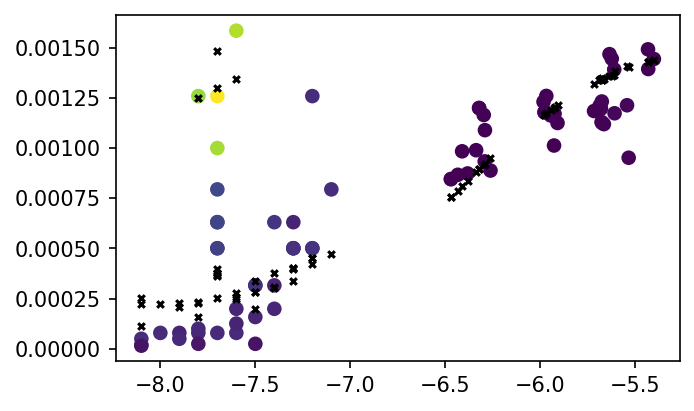

In [197]:
xv = xvars[-1][0]

offset = np.polyval(up, xv)

plt.scatter(logRp, DLi, c=xv)
plt.scatter(logRp, dpmid + nom(offset), marker='x', color='k', s=10)

### Hypotheses:

1. Li-HCO<sub>3</sub><sup>0</sup> ion pairs form at the growth surface, both facilitating Li incorporation (greater attachment, less detachment) and charge-balancing Li in crystal structure.
2. Li-CO<sub>3</sub><sup>-</sup> ion pairs form in solution and act as HCO<sub>3</sub><sup>-</sup>, adhering to the growth surface and aiding Li incorporation (more attachment).
3. Li-OH ion pairs form in solution, and reduce the activity of Li<sup>+</sup> in solution, reducing Li incorporation (less attachment).

#### Test:

Two phase SKM for both LiHCO3 and Li incorporation

In [122]:
def SKM_twophase(X, Kf1, Keq1, Kf2, Keq2, logRb):
    Rp, X1, X2 = X
    D1 = SKM(Rp, Kf1, Keq1, 10**logRb)
    D2 = SKM(Rp, Kf2, Keq2, 10**logRb)
    
    R1 = D1 * X1
    R2 = D2 * X2
    
    R = R1 + R2
    
    # return R
    
    D = R / X1
    
    return D

array([ 8.56073599e+00,  1.31035708e-10,  3.90357548e-01,  2.58862853e-06,
       -1.20615820e+01])

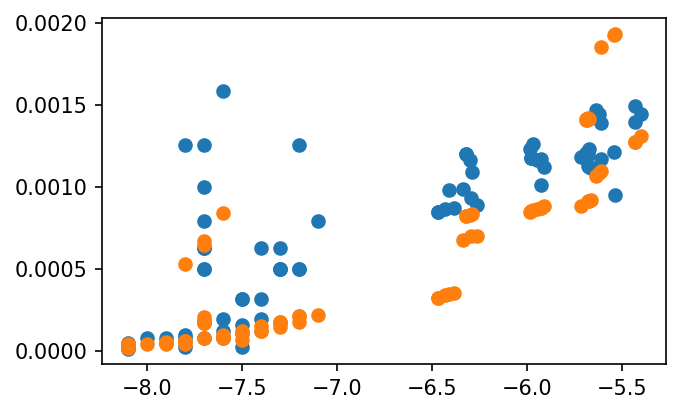

In [140]:
X1 = m_Li / m_Ca
X2 = LiHCO3 / m_Ca

X = Rp, X1, X2

p0 = 1e-2, 4e-3, 1e-3, 1e-5, -9

p, cov = curve_fit(SKM_twophase, X, DLi, p0=p0, sigma=DLi_err, maxfev=10000, bounds=([0, 0, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf]))
pred = SKM_twophase(X, *p)

# pred = SKM_twophase(X, *p0)

plt.scatter(logRp, DLi)
plt.scatter(logRp, pred)

p

In [141]:
def SKM_linfn(Rp, xvar, Kf, Keq, logRb, m):
    return SKM(Rp, Kf, Keq, 10**logRb) * (1 + xvar * m)

def log_likelihood_linfn(theta, Rp, xvar, DLi, Rp_err, DLi_err):
    Kf, Keq, logRb, m = theta
    model = SKM_linfn(Rp, xvar, Kf, Keq, logRb, m)
    sigma2 = DLi_err**2 + Rp_err**2
    return -0.5 * np.sum((DLi - model)**2 / sigma2 + np.log(sigma2))

def log_probability_linfn(theta, Rp, xvar, DLi, Rp_err, DLi_err):
    lp = log_prior(theta[:3])
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_linfn(theta, Rp, xvar, DLi, Rp_err, DLi_err)

# linear function of two x variables
def SKM_linfn2(Rp, x1, x2, Kf, Keq, logRb, m1, m2):
    return SKM(Rp, Kf, Keq, 10**logRb) + x1 * m1 + x2 * m2

def log_likelihood_linfn2(theta, Rp, x1, x2, DLi, Rp_err, DLi_err):
    Kf, Keq, logRb, m1, m2 = theta
    model = SKM_linfn2(Rp, x1, x2, Kf, Keq, logRb, m1, m2)
    sigma2 = DLi_err**2 + Rp_err**2
    return -0.5 * np.sum((DLi - model)**2 / sigma2 + np.log(sigma2))

def log_probability_linfn2(theta, Rp, x1, x2, DLi, Rp_err, DLi_err):
    lp = log_prior(theta[:3])
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_linfn2(theta, Rp, x1, x2, DLi, Rp_err, DLi_err)

In [142]:
initial = 1.65e-03,  4.13e-07, -7, 0

nwalkers = 32
ndim = len(initial)

start = initial + 1e-7 * np.random.randn(nwalkers, len(initial))

# neutral_ind = np.isclose(la_HCO3, -2.8, atol=0.2)
# xvar = la_OH - la_OH[neutral_ind].mean()

# x1 = Li_HCO3
# x2 = mu

x1 = Li_HCO3 * mu

ind = np.ones(Rp.shape, dtype=bool)
# inputs = (Rp[ind], x1[ind], x2[ind], DLi[ind], Rp_err[ind], DLi_err[ind])
inputs = (Rp[ind], x1[ind], DLi[ind], Rp_err[ind], DLi_err[ind])

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_linfn, args=inputs)
sampler2.run_mcmc(start, 5000, progress=True);


100%|██████████| 5000/5000 [00:20<00:00, 244.30it/s]


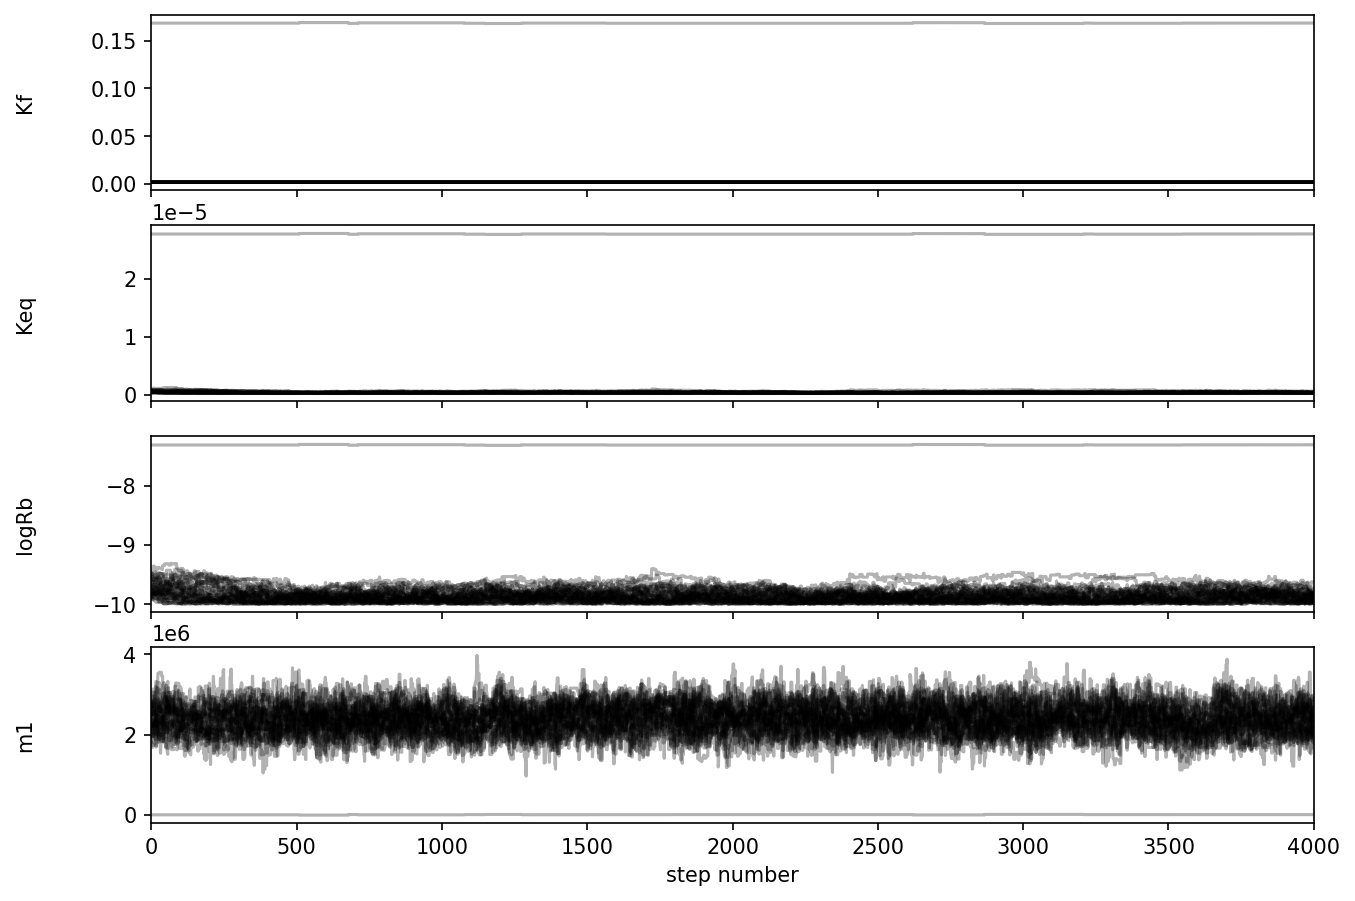

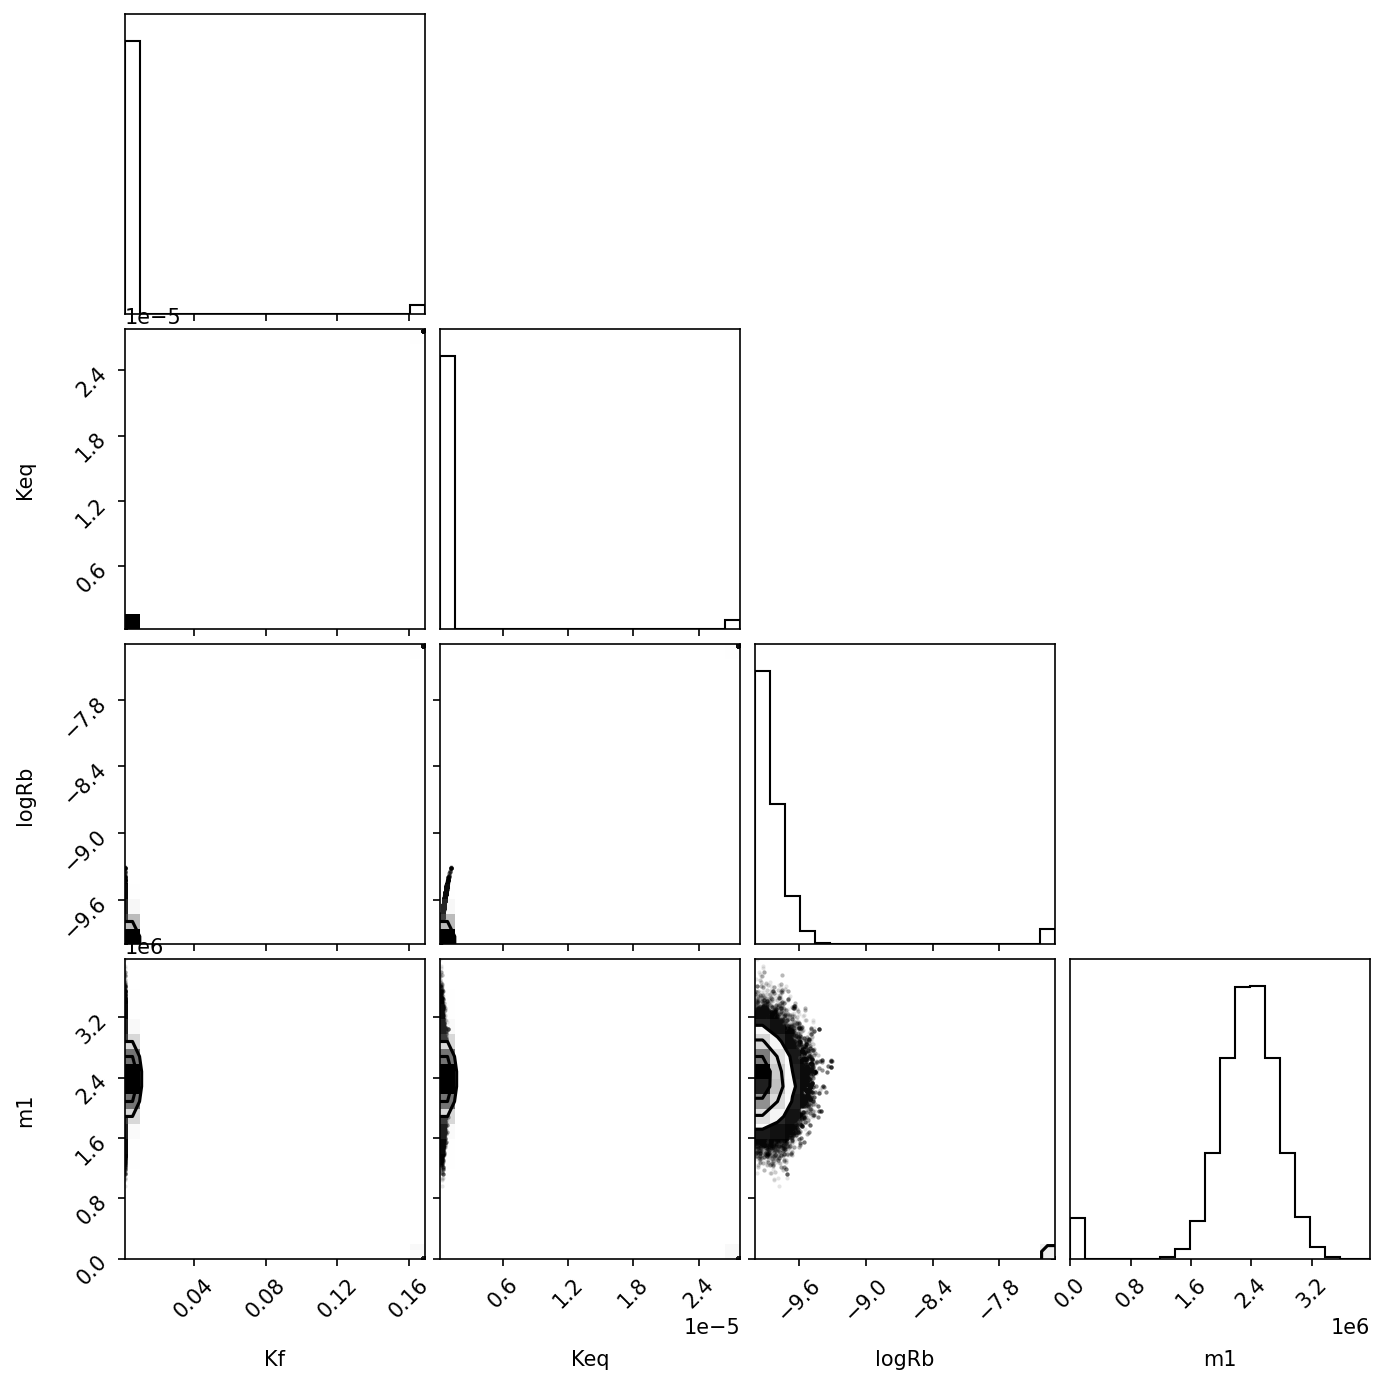

In [143]:
burnin=1000
samples = sampler2.get_chain(discard=burnin)
flat_samples = sampler2.get_chain(discard=burnin, flat=True)
labels = 'Kf', 'Keq', 'logRb', 'm1', 'm2'

fig, axs = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axs[-1].set_xlabel("step number");

corner.corner(flat_samples, labels=labels);

In [144]:
# pred = SKM_linfn2(Rp.reshape(-1,1), x1.reshape(-1,1), x2.reshape(-1,1), *flat_samples.T)
pred = SKM_linfn(Rp.reshape(-1,1), x1.reshape(-1,1), *flat_samples.T)

CI = 0.95
plo, pmid, phi = np.quantile(pred, [0.5 - CI / 2, 0.5, 0.5 + CI / 2], axis=1)

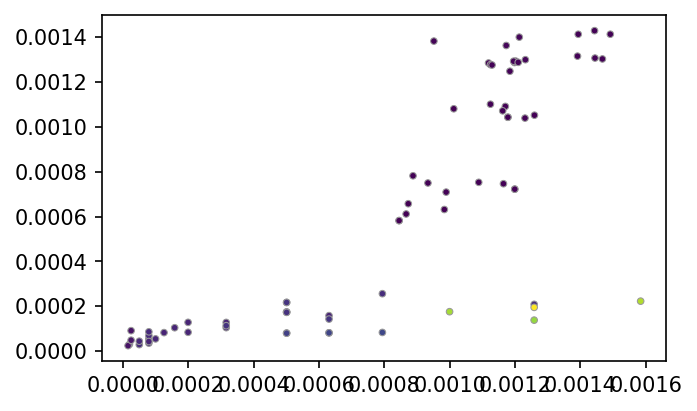

In [145]:
plt.scatter(DLi, nom(pmid), c=x1, s=10, lw=0.5, edgecolor=(.6,.6,.6))

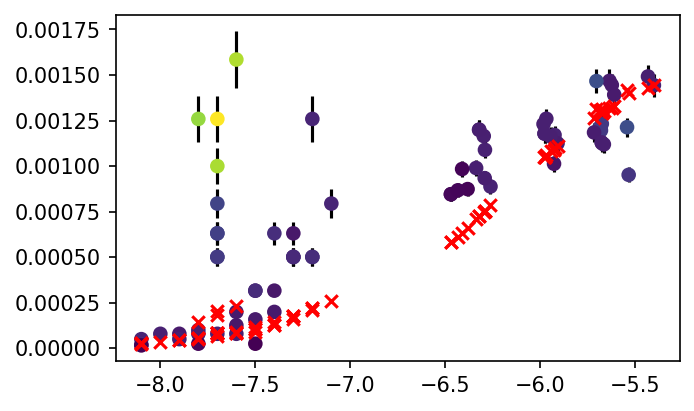

In [ ]:
plt.errorbar(np.log10(Rp), DLi, yerr=DLi_err, fmt='none', c='k', zorder=-3)
plt.scatter(np.log10(Rp), DLi, c=Li_HCO3)

plt.scatter(np.log10(Rp), pmid, marker='x', color='r')

# par = *basic_skm, 0, 0
# pred = SKM_linfn2(Rp.reshape(-1,1), x1.reshape(-1,1), x2.reshape(-1,1), *par)
# plt.scatter(np.log10(Rp), pred, marker='x', color='k')


## 2 phase partitioning

Partitioning in terms of free Li and Li-HCO3

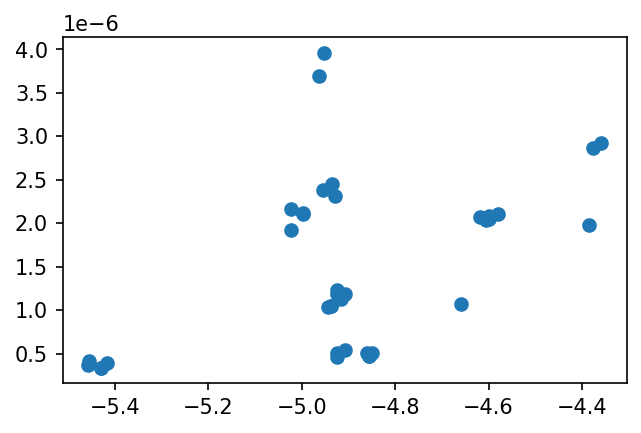

In [61]:
plt.scatter(df.llnl.la_NaHCO3, nom(df.R.R_13C))


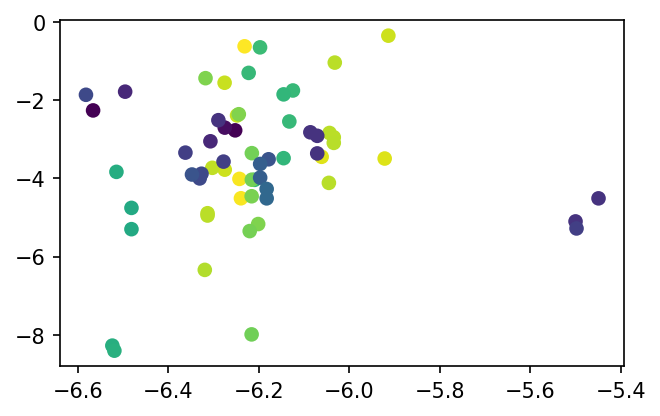

In [107]:
plt.scatter(la_LiHCO3, e7Li, c=np.log10(Rp))

# plt.scatter(df.llnl_LiHCO3.la_LiHCO3, nom(df.Li_isotopes_vs_fluid.epsilon_og))


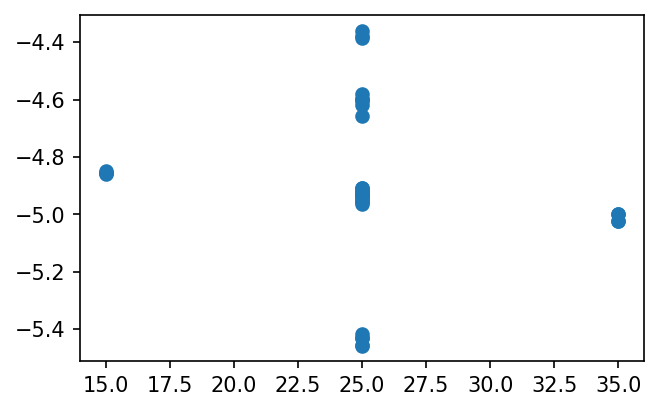

In [47]:
plt.scatter(df.llnl['temp(C)'], df.llnl.la_NaHCO3)

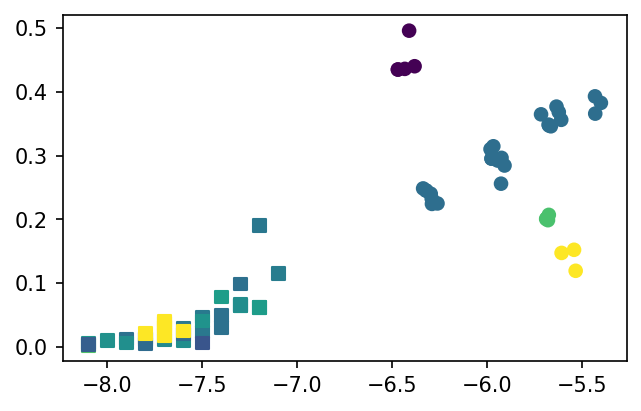

In [123]:
#  

# DLiHCO3 = solid_LiCa / ((10**la_Li * 10**la_HCO3) / sol_Ca)
DLiHCO3 = solid_LiCa / (10**la_LiHCO3 / sol_Ca)

# cvar = mu
cvar = DIC
vmin = cvar.min()
vmax = cvar.max()
vmax = 4000e-6

fm  = {
    'This Study': 0.5,
    'Fuger2019': 0.2
}  # impact of ionic strength?

for s in np.unique(study):
    ind = study == s
    plt.scatter(np.log10(Rp)[ind], (1 - fm[s]) * DLi[ind] + fm[s] * DLiHCO3[ind], marker=mdict[s], c=cvar[ind], vmin=vmin, vmax=vmax)
    
    
# fit as two separate SKM models - one for free Li, one for Li-HCO3 ion pairs.
# shared Rb; possibly different parameters for different ionic strengths?
# transformation on surface? (e.g. Li-HCO3 -> Li+)